In [1]:
import sys
!{sys.executable} -m pip install numpy pandas scikit-fuzzy matplotlib --user

import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("coffee_data.csv")
data.head()

,coffee_name,intensity,price,customer_rating
0,Coffee_1,7,39,1
1,Coffee_2,4,18,3
2,Coffee_3,8,21,5
3,Coffee_4,5,40,2
4,Coffee_5,7,44,2


In [2]:
# Input variables
intensity = ctrl.Antecedent(np.arange(1, 11, 1), 'intensity')
price = ctrl.Antecedent(np.arange(5, 51, 1), 'price')
customer_rating = ctrl.Antecedent(np.arange(1, 6, 1), 'customer_rating')

# Output variable
coffee_quality = ctrl.Consequent(np.arange(0, 11, 1), 'coffee_quality')

In [3]:
# Intensity
intensity['low'] = fuzz.trapmf(intensity.universe, [1,1,3,5])
intensity['medium'] = fuzz.trimf(intensity.universe, [4,5.5,7])
intensity['high'] = fuzz.trapmf(intensity.universe, [6,8,10,10])

# Price
price['cheap'] = fuzz.trapmf(price.universe, [5,5,15,25])
price['medium'] = fuzz.trimf(price.universe, [20,30,40])
price['expensive'] = fuzz.trapmf(price.universe, [35,45,50,50])

# Customer rating
customer_rating['low'] = fuzz.trapmf(customer_rating.universe, [1,1,2,3])
customer_rating['medium'] = fuzz.trimf(customer_rating.universe, [2,3,4])
customer_rating['high'] = fuzz.trapmf(customer_rating.universe, [3,4,5,5])

# Coffee quality
coffee_quality['low'] = fuzz.trapmf(coffee_quality.universe, [0,0,3,5])
coffee_quality['medium'] = fuzz.trimf(coffee_quality.universe, [4,5.5,7])
coffee_quality['high'] = fuzz.trapmf(coffee_quality.universe, [6,8,10,10])

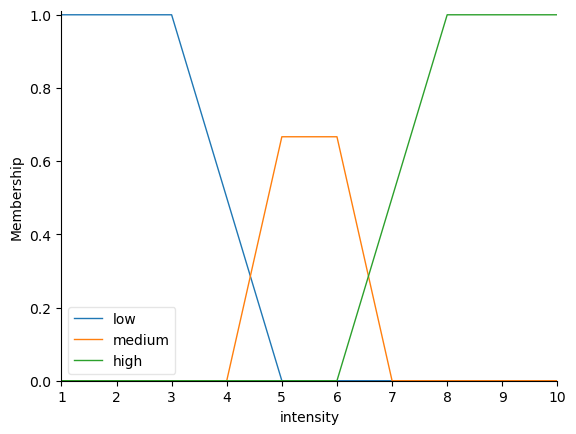

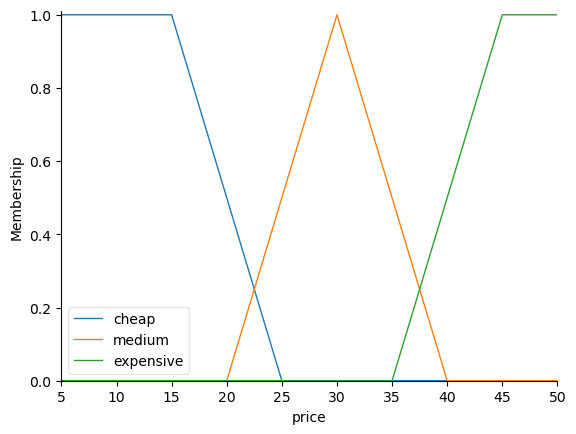

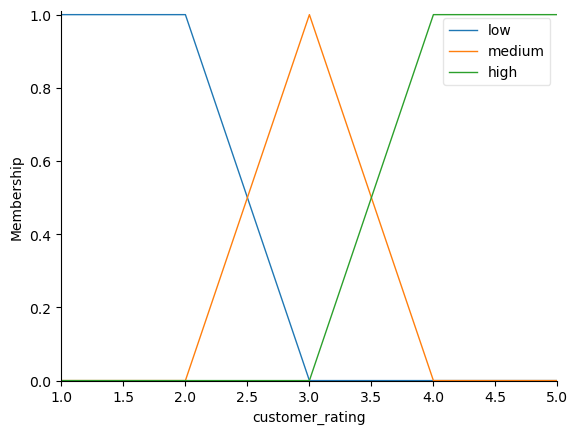

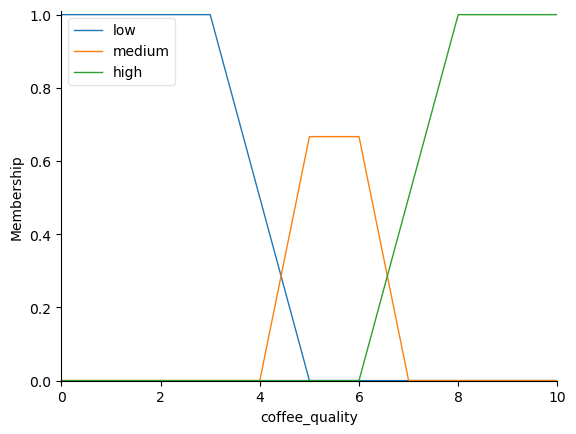

In [13]:
intensity.view()
plt.show()

price.view()
plt.show()

customer_rating.view()
plt.show()

coffee_quality.view()
plt.show()

In [5]:
rule1 = ctrl.Rule(intensity['high'] & customer_rating['high'], coffee_quality['high'])
rule2 = ctrl.Rule(intensity['medium'] & price['medium'], coffee_quality['medium'])
rule3 = ctrl.Rule(intensity['low'] | customer_rating['low'], coffee_quality['low'])
rule4 = ctrl.Rule(price['cheap'] & customer_rating['high'], coffee_quality['medium'])
rule5 = ctrl.Rule(intensity['high'] & price['expensive'], coffee_quality['high'])
rule6 = ctrl.Rule(intensity['medium'] & customer_rating['medium'], coffee_quality['medium'])

In [6]:
rule_fallback = ctrl.Rule(intensity['medium'] | customer_rating['medium'] | price['medium'], coffee_quality['medium'])
coffee_quality_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule_fallback])

In [7]:
def compute_coffee_quality(row):
    sim = ctrl.ControlSystemSimulation(coffee_quality_ctrl)
    try:
        # Clip input agar sesuai range
        intensity_val = np.clip(row['intensity'], intensity.universe[0], intensity.universe[-1])
        price_val = np.clip(row['price'], price.universe[0], price.universe[-1])
        rating_val = np.clip(row['customer_rating'], customer_rating.universe[0], customer_rating.universe[-1])
        
        # Set input
        sim.input['intensity'] = intensity_val
        sim.input['price'] = price_val
        sim.input['customer_rating'] = rating_val
        
        # Compute fuzzy output
        sim.compute()
        
        # Hapus debug print
        # print(sim.output.keys())
        
        return sim.output['coffee_quality']
    except Exception as e:
        print(f"Error computing row {row.name}: {e}")
        print(f"Inputs: intensity={row['intensity']}, price={row['price']}, rating={row['customer_rating']}")
        return np.nan

In [8]:
data['coffee_quality_score'] = data.apply(compute_coffee_quality, axis=1)
data.head()

,coffee_name,intensity,price,customer_rating,coffee_quality_score
0,Coffee_1,7,39,1,3.728791
1,Coffee_2,4,18,3,3.465116
2,Coffee_3,8,21,5,7.763385
3,Coffee_4,5,40,2,2.906250
4,Coffee_5,7,44,2,3.927536


In [9]:
def classify_quality(score):
    if score >= 6:
        return 'High'
    elif score >= 4:
        return 'Medium'
    else:
        return 'Low'

# Terapkan ke dataset
data['coffee_quality_category'] = data['coffee_quality_score'].apply(classify_quality)

# Cek hasil
data.head(10)

,coffee_name,intensity,price,customer_rating,coffee_quality_score,coffee_quality_category
0,Coffee_1,7,39,1,3.728791,Low
1,Coffee_2,4,18,3,3.465116,Low
2,Coffee_3,8,21,5,7.763385,High
3,Coffee_4,5,40,2,2.906250,Low
4,Coffee_5,7,44,2,3.927536,Low
5,Coffee_6,10,8,1,2.041667,Low
6,Coffee_7,3,6,4,2.906250,Low
7,Coffee_8,7,10,1,2.041667,Low
8,Coffee_9,8,46,4,8.444444,High
9,Coffee_10,5,8,2,2.906250,Low


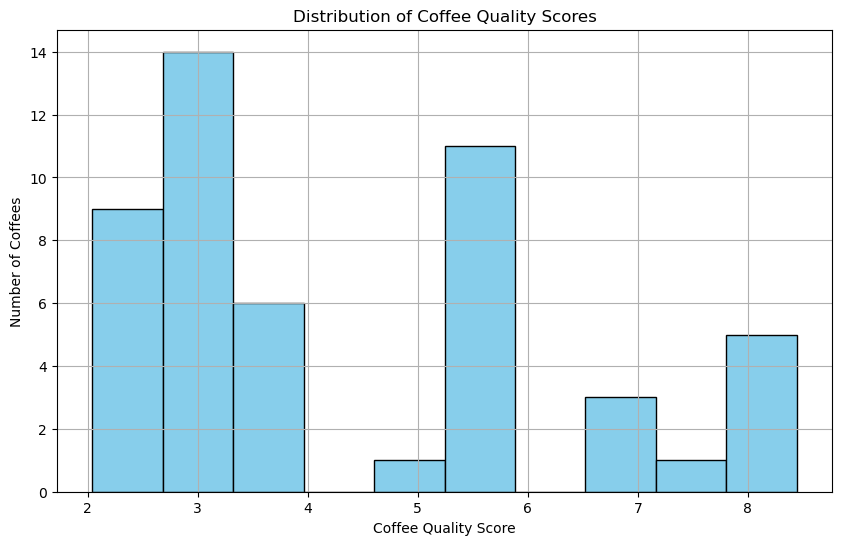

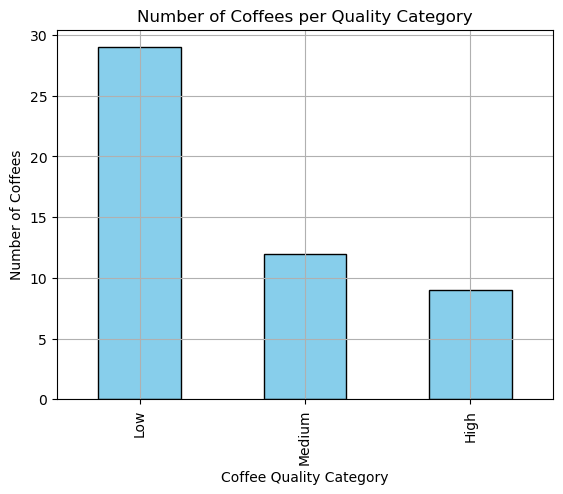

Coffee Quality Category Counts:
coffee_quality_category
Low       29
Medium    12
High       9
Name: count, dtype: int64


In [10]:
# Histogram kualitas coffee
plt.figure(figsize=(10,6))
plt.hist(data['coffee_quality_score'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Coffee Quality Scores')
plt.xlabel('Coffee Quality Score')
plt.ylabel('Number of Coffees')
plt.grid(True)
plt.show()

# Count kategori
category_counts = data['coffee_quality_category'].value_counts()
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Coffees per Quality Category')
plt.xlabel('Coffee Quality Category')
plt.ylabel('Number of Coffees')
plt.grid(True)
plt.show()

# Print insights
print("Coffee Quality Category Counts:")
print(category_counts)

In [11]:
data.to_csv("coffee_data_with_quality.csv", index=False)